In [1]:
%matplotlib inline
import elfi
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from elfi.examples import copula as copula_example_model
import elfi.methods.copula as cop

According to the Bernstein-von Mises theorem the posterior $\pi(\theta \mid y_{obs})$ is asymptotically normal. [ref] uses this fact to approach ABC inference from a structured approach to density estimation. In this approach the $p$-dimensional posterior is approximated using a meta-Gaussian distribution. Meta-Gaussian distributions have the property that the full joint distribution can be approximated from all bivariate marginals. This allows us to estimate the lower dimensional marginal distributions separately and in parallel.

We will use a simple toy example to illustrate this. Assume that the data $y$ is generated from a multivariate Gaussian $y \sim N_p(\theta, I)$, $p \geq 2$. We use a "twisted" Gaussian distribution as our prior, which is obtained by transforming the Gaussian distribution $N(0, \Sigma)$, where $\Sigma = \text{diag}([100, 1, 1, \dots, 1])$ by the function $\phi_b(x) = (x_1, x_2 + b x_1^2 - 100 b, x_3, \dots, x_p$). We use $b=0.1$ to get a strong correlation between the first two components.

We use $y_{obs} = [10, 0, \dots, 0]$ as the oberved data. We use the identity function as the summary statistic $s = S(y) = y$. Exploting our knowledge of the model, we set the subset of the summary informative about $\theta_i$ to be $s_i$ with the expection of the second component which we set to $s_{(2)} = (s_1, s_2)$. For the bivariate marginals, we use the unions of the previous summary statistics i.e $s_{(2, 3)} = (s_1, s_2, s_3)$.

The meta-Gaussian distribution has the probability density function

$$p(\theta) = \frac{1}{|\Lambda|^{\frac12}} \exp\left\{ \frac12 \eta^{T}(I - \Lambda^{-1})\eta \right\} \prod_{i=1}^{p} g_i(\theta_i)$$

Here $R$ is the correlation matrix, that specifies the correlations between the components of the distributions and $g_i$ are the density functions of the marginal distributions.

In [2]:
def transform(x, b=0.1):
    nx = x.copy()
    nx[1] = nx[1] + b*nx[0]**2 - 100*b
    return nx

def inverse(y, b=0.1):
    ny = y.copy()
    ny[1] = 100*b - b*ny[0]**2 + ny[1]
    return ny

The meta-Gaussian distribution can be used to construct joint distributions with specific marginals and a correlation between the components. For example, to construct a distribution with beta and gamma marginals with a correlation of 0.5

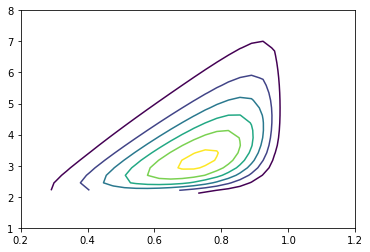

In [3]:
from elfi.utils import tabulate

rho = 0.5
corr = np.array([[1, rho],
                 [rho, 1]])
cov = corr
marginals = [ss.beta(5, 2),
             ss.gamma(2, 2)]

mg = cop.MetaGaussian(cov=cov, marginals=marginals)

t1 = np.linspace(0.2, 1.2, 30)
t2 = np.linspace(1, 8, 30)
grid, vals = tabulate(mg.pdf, t1, t2)
plt.contour(*grid, vals);

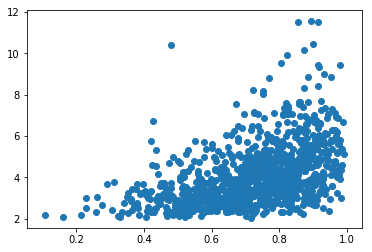

In [8]:
X = mg.rvs(1000)
plt.scatter(X[:, 0], X[:, 1])

To use the meta-Gaussian distribution for ABC inference we need to estimate the univariate marginal distributions using a some form of density estimation. The ELFI `EmpiricalDistribution` class estimates density functions of univariate samples using gaussian kernel density estimation. To estimate the cumulative distribution function it uses linear interpolation of the empirical cumulative distribution function.

In [9]:
from elfi.methods.empirical_density import EmpiricalDensity
density_estimate = EmpiricalDensity(np.random.randn(1000))

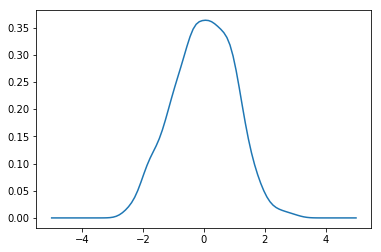

In [10]:
t = np.linspace(-5, 5, 100)
plt.plot(t, density_estimate.pdf(t));

The correlation matrix of the meta-Gaussian distribution can be estimated by computing the linear correlation between all the bivariate samples.

# Copula ABC

To use the structured estimation in [ref] we need to construct an inference model where we have a discrepancy node for each informative subset of the summary statistic. It is difficult to make a inference method for the general case, but we do provide some helpful utilities for constructing a suitable inference model. These utilities assume that there is a single summary statistic and the informative subsets can be constructed by taking a subset of the components. We also assume that there is only a single multivariate prior distribution. In other cases the inference model will have to be constructed by the user.

If in addition to the previous conditions the bivariate informative subsets of the summary statistic are simply the union of the univariate ones it suffices to specify which indices of the summary statistic are informative for a given component of the prior distribution. This is specified in a dictionary where the keys specify the component of the prior distribution and the values specify the subsets of the summary statistic which are informative for the component.

In the running example, the informative indices are the same as the component itself with the expection of the second component.

In [12]:
p = 3

informative_indices = {i: set([i]) for i in range(p)}
informative_indices[1] = {0, 1}
informative_indices

{0: {0}, 1: {0, 1}, 2: {2}}

The utility function `make_union` completes the definition of the informative indices by making the unions of the univariate statistics to be informative of the bivariate ones.

In [15]:
full_indices = cop.make_union(informative_indices); full_indices

{0: {0}, 1: {0, 1}, 2: {2}, (0, 1): {0, 1}, (0, 2): {0, 2}, (1, 2): {0, 1, 2}}

Next we need to specify the inference model. The example model only has the prior distribution and the simulator defined since we will construct the necessary additional nodes to perform the inference.

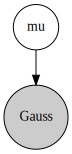

In [14]:
m = copula_example_model.get_model(p)
simulator = m['Gauss']
elfi.draw(m)

The `make_distances` function adds summary and distance nodes corresponding to the specified indices.


Should the inference models be separate submodels instead? Should the utility functions be pure functions i.e return a new model instead of modifying the old model in place?

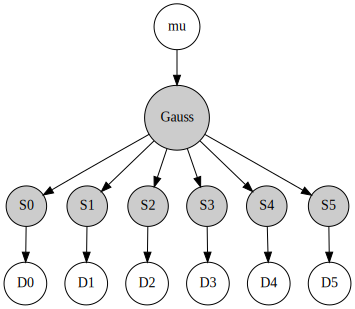

In [18]:
# Do not modify the original model
mcopy = m.copy()
simulator = mcopy['Gauss']

distance_nodes = cop.make_distances(full_indices, simulator)
elfi.draw(mcopy)

Finally we must specify which ABC method to use for each of the submodels. The `make_samplers` function will construct a dictionary of sampling algorithms for each of the marginal distributions.

In [22]:
samplers = cop.make_samplers(distance_nodes, elfi.Rejection, batch_size=100); samplers

{0: <elfi.methods.parameter_inference.Rejection at 0x7fc7a8d59160>,
 1: <elfi.methods.parameter_inference.Rejection at 0x7fc7a8d592e8>,
 2: <elfi.methods.parameter_inference.Rejection at 0x7fc7a8d59390>,
 (0, 1): <elfi.methods.parameter_inference.Rejection at 0x7fc7a8d59550>,
 (0, 2): <elfi.methods.parameter_inference.Rejection at 0x7fc7a8d59400>,
 (1, 2): <elfi.methods.parameter_inference.Rejection at 0x7fc7a8d59780>}

The `get_samples` function can be used to obtain samples from a specific marginal.

In [26]:
# sample from the first component
sample0 = cop.get_samples(inx=0, samplers=samplers, n_samples=10, parameter='mu', quantile=0.01)
sample01 = cop.get_samples(inx=(0, 1), samplers=samplers, n_samples=10, parameter='mu', quantile=0.1)

The correlations between the components of the vector $\eta$ are estimated from the bivariate samples. Since we have $\eta_i = \Phi^{-1}(G_i(\theta_i))$ they can be estimated as follows: Let $r_i$ and $q_j$ be the ranks of the components of the bivariate sample respectively. The corresponding entry in the correlation matrix $\Lambda$ is computed by setting $\eta_i = \Phi^{-1}(\frac{r_i}{n + a})$ and $\eta_j = \Phi^{-1}(\frac{q_j}{n + a})$ and computing the correlation coefficient between them. This can be done with the `_estimate_correlation` function.

In [28]:
cop._estimate_correlation((0, 1), samplers=samplers, n_samples=100, quantile=0.01)

0.79489358730167792

In [ ]:
def prior(x, dim=p):
    diag = np.ones(len(x))
    diag[0] = 100
    cov = np.diag(diag)
    mvn = ss.multivariate_normal(cov=cov)
    return mvn.pdf(inverse(x))

def likelihood(theta, y=None, dim=p):
    if y == None:
        y = np.zeros(p)
        y[0] = 10
    return ss.multivariate_normal(mean=theta, cov=np.diag(np.ones(p))).pdf(y)

def posterior_pdf(x, y=None, dim=p):
    if y == None:
        y = np.zeros(p)
        y[0] = 10
        
    #     evaluated at [x1, x2, 0, ..., 0]
    theta = np.zeros(dim)
    theta[:2] = x
    return prior(theta, dim)*likelihood(theta, y, dim)

In [ ]:
informative_indices = {i: set([i]) for i in range(p)}
informative_indices[1] = {0, 1}

In [ ]:
posterior = cop.estimate(informative_indices, simulator=simulator,
                         samplerkwargs={'batch_size': 100},
                         n_samples=100, quantile=0.01)

In [ ]:
from elfi.visualization.visualization import compare, overlay
from elfi.utils import tabulate


def marginal(x, dim=p):
    """The posterior evaluated at [x1, x2, 0, 0, ..., 0]"""
    arr = np.zeros(dim)
    arr[:2] = x
    return posterior.pdf(arr)


t1 = np.linspace(7, 14, 30)
t2 = np.linspace(-2.5, 2.5, 30)

overlay({marginal: {}, posterior_pdf: {'linestyles': 'dashed'}}, t1, t2)

In [ ]:
p = 30

m2 = copula_example_model.get_model(p)
d = elfi.Distance('euclidean', m2['Gauss'])
rej = elfi.Rejection(d)
res = rej.sample(n_samples=500, quantile=0.01)

In [ ]:
post = res.outputs['mu'][:, [0, 1]]

In [ ]:
plt.scatter(post[:, 0], post[:, 1])

In [ ]:
kde = ss.gaussian_kde(np.transpose(post))

In [ ]:
kde.pdf(np.array([0,0]))

In [ ]:
overlay({kde.pdf: {}, posterior_pdf: {}}, t1, t2)